# Notes

* Data analysis - hypothesis tests, confidence intervals, p-values?
* Parch = parents or children. Is this a useful feature on its own? Before trying to split into parents/children (e.g. by checking for family names), see if parch is statistically significant.
* Sibsp = siblings or spouses
* Would it be useful to create a categorical variable from "Age" that denotes child, teen, young adult, etc.?
* Is it useful to split the data by "Survived" and check for statistical significance between the distributions?
* Besides correlation, are there ways to analyze categorical-categorical relationships? What about categorical-numerical relationships?
    * I think you need to make a distinction b/w ordinal and nominal attributes as well. I don't think you can use correlation for nominal attributes.
* Does it make sense to take the most promising features based on univariate analysis and look more closely at the multivariate analysis?
* Calculate survival rate by age after histogram binning? This is like converting numerical to categorical. Is this useful for feature engineering or just visualization? Statistical testing?
* You don't need to bin for decision trees - they do that already
* Feature selection/feature extraction - yes, you can do EDA/statistical tests, but you also need to check performance in training and evaluation. Feature importance for decision trees, feature permutation tests. Feature selection algorithms. Are there feature extraction algorithms?
    * I think you should spend less time on the statistical testing and instead use EDA to get an intuitive feel for how the features affect the label. Then use training/eval to confirm your intuition and refine your feature selection/feature engineering.

* Create transformation pipeline with the ability to try different data preparation steps, models, and evaluation
    * Using original features
    * Using feature engineering
    * Using different methods of handling missing values
* Dimensionality reduction

# Load libraries and datasets

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score


In [210]:
df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")

# First view of the training data

* Survival rate across all passengers is 38.38%

In [211]:
df = df_train
# df = df.astype({"Pclass": "category", "Sex": "category", "Embarked": "category", "Survived": "category"})
# print(df.info())
print(df.columns)
df.head()

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [82]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# df.describe(include="category")

In [206]:
print(f"Number of samples = {df.shape[0]}, number of attributes = {df.shape[1]}\n")
# print(f"Attributes = {df.columns}\n")
print(f"Number of duplicates = {sum(df.duplicated())}\n")
print(f"Percentage of missing values = {round(df.isna().sum().sum() / df.size * 100, 1)}\n")

print("Data Types\n---------------------")
print(df.dtypes)
print("")

print("Missing Values\n---------------------------")
print(df.isna().sum())
print("")

# print(df.isna().sum().sum()

# df.describe()
# df.describe(include="object")


Number of samples = 891, number of attributes = 12

Number of duplicates = 0

Percentage of missing values = 8.1

Data Types
---------------------
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing Values
---------------------------
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64



# Taking natural log

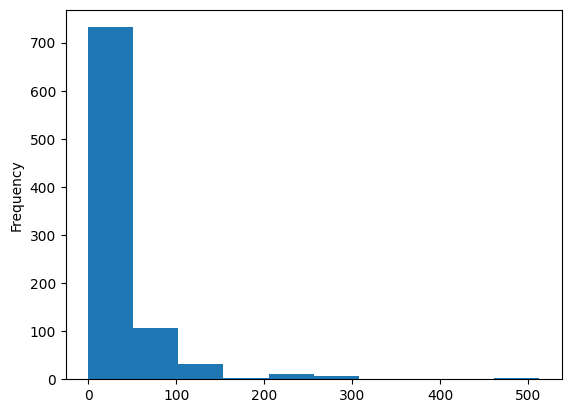

In [26]:
df_num = df.select_dtypes(include=["int64", "float64"]).drop(["PassengerId"], axis="columns").copy()
# df_num.columns
# df_num["Fare"] = np.log(df_num["Fare"].replace(0, np.nan))
df_num["Fare"].plot(kind="hist")
plt.show()
# for col in ["Fare"]:
#     df_num[col] = np.log(df_num[col])
# df_num.head()
# sum(df_num["Fare"] == 0) # 15 people got on for free

# PassengerId - drop

In [207]:
print(np.diff(df["PassengerId"]).min())
print(np.diff(df["PassengerId"]).max())

1
1


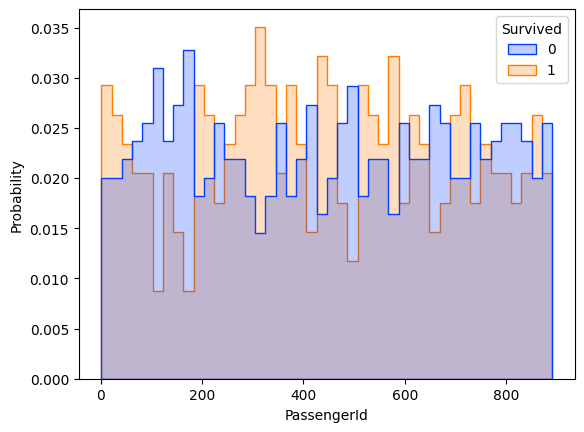

In [211]:
ax = sns.histplot(df, x="PassengerId", hue="Survived", stat="probability", \
                  binwidth=20, common_norm=False, multiple="layer", \
                  element="step", palette="bright")

# Pclass - passthrough

Analysis:
* Higher Pclass = higher rate of survival
* Pclass 1 and 2 have higher rates of survival than the overall; Pclass 3 has lower rate

In [389]:
df.Pclass.value_counts().sort_index()

Pclass
1    216
2    184
3    491
Name: count, dtype: int64

In [390]:
df.groupby(["Pclass"]).Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

[3 1 2]
int64


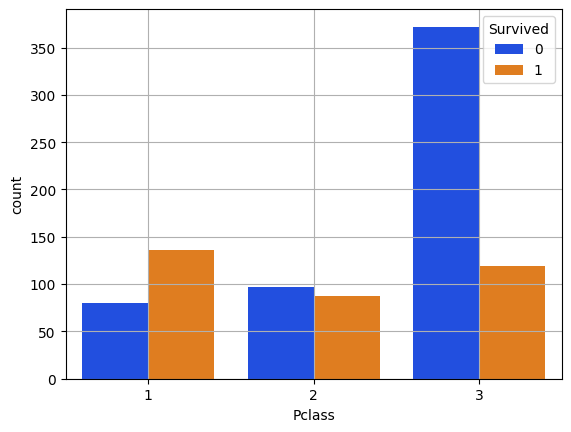

In [387]:
print(df["Pclass"].unique())
print(df["Pclass"].dtype)

ax = sns.countplot(df, x="Pclass", hue="Survived", palette="bright")
ax.grid()

# Sex - ordinal encoding

Analysis:
* More males than females on board
* You are much more likely to survive if you are female (double the overall rate). Males have roughly half the overall rate of survival.

In [370]:
df.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [386]:
df.groupby(["Sex"]).Survived.mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

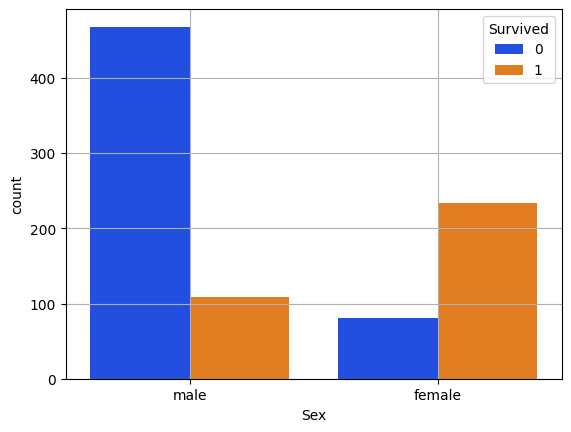

In [385]:
# ax = sns.countplot(df, x="Sex", hue="Survived", stat="probability", palette="bright")
ax = sns.countplot(df, x="Sex", hue="Survived", palette="bright")
ax.grid()

# Age - passthrough, missing indicator/impute NaN

Analysis:
* Young Age = more likely to survive
* Age is correlated with Pclass - higher Pclass = higher Age

Analysis of missing Ages:
* 20% of Ages are missing
* If Age is missing, it's more likely the passenger died (70% vs. 60%)
* The missing Ages are not randomly distributed
    * Lower class (Pclass3) is more likely to be missing Ages
    * People without any family are more likely to be missing Ages
* Groupby Pclass, TotalFam, Fare (bracket), Titles, CabinMissing and calculate mean/median for each groupby - use this to impute
    * Most common missing groups
        * Titles = Mr., Pclass = 3, TotalFam = 0 -> median Age = 27
        * Titles = Mr., Pclass = 1, TotalFam = 0 -> median Age = 45
        * Titles = Miss., Pclass = 3, TotalFam = 0 -> median Age = 22


## Age univariate

In [331]:
df["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

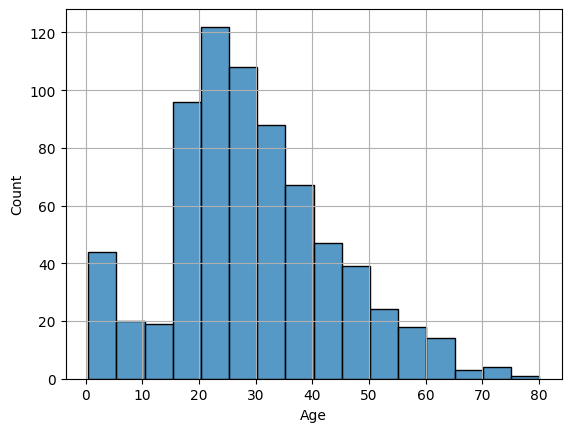

In [376]:
ax = sns.histplot(df, x="Age", binwidth=5)
ax.grid()

## Age vs. Survived

In [165]:
print(df.groupby(["Survived"]).Age.describe())
print("")
print(df.groupby(["Survived"]).AgeImputed.describe())
print("")

          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0

          count       mean        std   min    25%   50%    75%   max
Survived                                                             
0         549.0  29.863843  13.290987  1.00  22.00  27.0  37.00  74.0
1         342.0  28.321404  14.433924  0.42  19.25  27.0  37.75  80.0



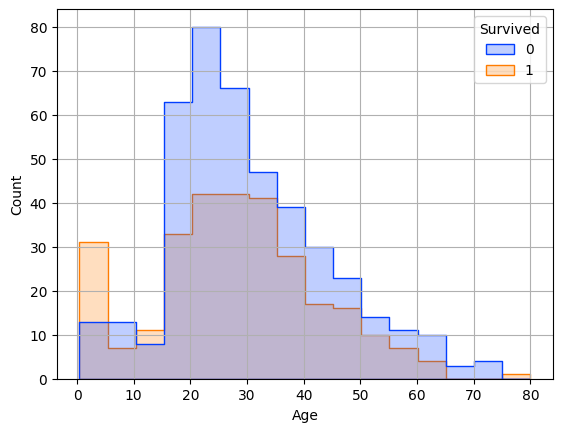

In [421]:
ax = sns.histplot(df, x="Age", hue="Survived", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

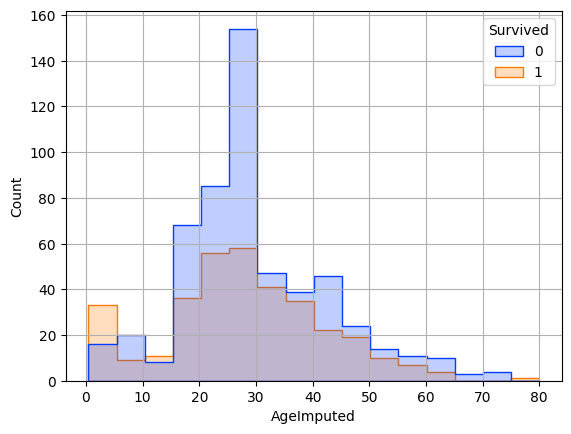

In [166]:
ax = sns.histplot(df, x="AgeImputed", hue="Survived", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

## Age vs. Pclass

In [167]:
print(df.groupby(["Pclass"]).Age.describe())
print("")
print(df.groupby(["Pclass"]).AgeImputed.describe())
print("")

        count       mean        std   min   25%   50%   75%   max
Pclass                                                           
1       186.0  38.233441  14.802856  0.92  27.0  37.0  49.0  80.0
2       173.0  29.877630  14.001077  0.67  23.0  29.0  36.0  70.0
3       355.0  25.140620  12.495398  0.42  18.0  24.0  32.0  74.0

        count       mean        std   min   25%   50%   75%   max
Pclass                                                           
1       216.0  38.923241  13.904000  0.92  29.0  39.0  48.0  80.0
2       184.0  29.884946  13.573790  0.67  23.0  30.0  36.0  70.0
3       491.0  24.796171  11.342772  0.42  19.0  26.0  29.0  74.0



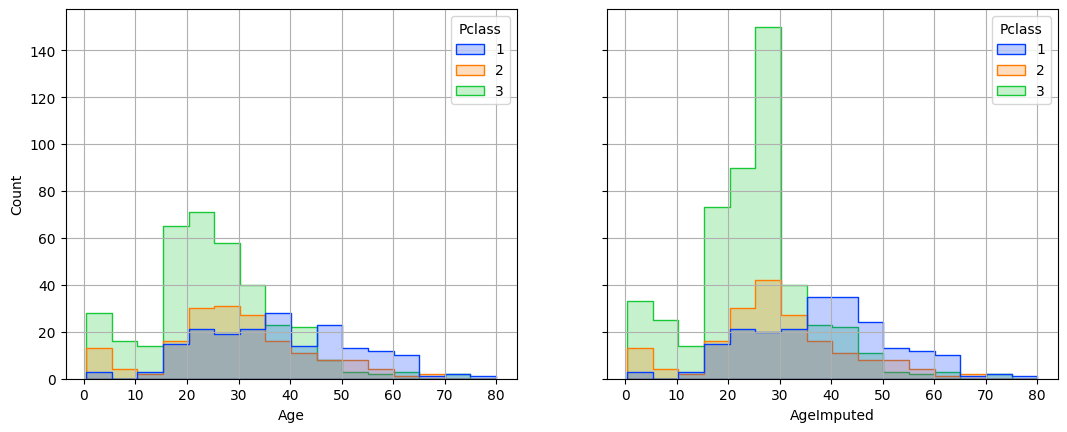

In [176]:
# ax = sns.histplot(df, x="Age", hue="Pclass", stat="probability", \
#                   binwidth=5, common_norm=False, multiple="layer", \
#                   element="step", palette="bright", \
#                     kde=False, kde_kws={"bw_adjust": 0.5})

f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.histplot(df, x="Age", hue="Pclass", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright", ax=axs[0])
sns.histplot(df, x="AgeImputed", hue="Pclass", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright", ax=axs[1])
axs[0].grid()
axs[1].grid()

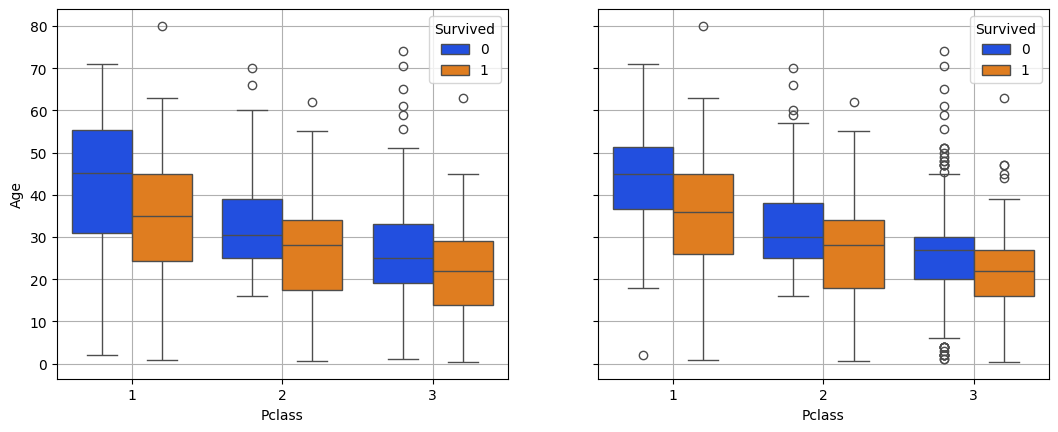

In [177]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.boxplot(df, x="Pclass", y="Age", hue="Survived", palette="bright", ax=axs[0])
sns.boxplot(df, x="Pclass", y="AgeImputed", hue="Survived", palette="bright", ax=axs[1])
axs[0].grid()
axs[1].grid()

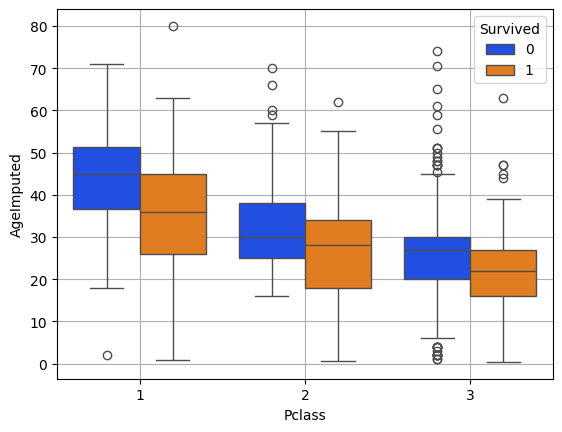

In [169]:
ax = sns.boxplot(df, x="Pclass", y="AgeImputed", hue="Survived", palette="bright")
ax.grid()

## Age vs. Sex

In [26]:
df.groupby(["Sex"]).Age.describe()

,count,mean,std,min,25%,50%,75%,max
Sex,,,,,,,,
female,261.0,27.915709,14.110146,0.75,18.0,27.0,37.0,63.0
male,453.0,30.726645,14.678201,0.42,21.0,29.0,39.0,80.0


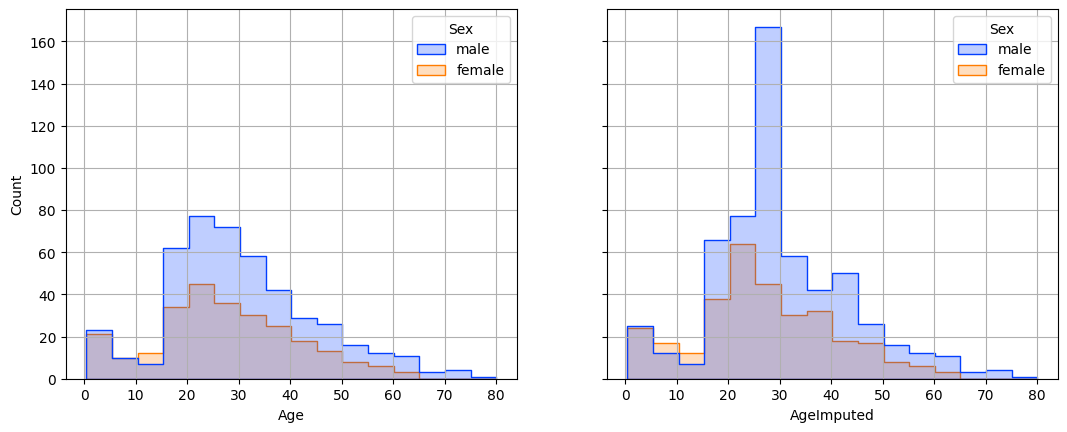

In [178]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))

sns.histplot(df, x="Age", hue="Sex", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright", ax=axs[0])
sns.histplot(df, x="AgeImputed", hue="Sex", \
                  binwidth=5, multiple="layer", \
                  element="step", palette="bright", ax=axs[1])
axs[0].grid()
axs[1].grid()

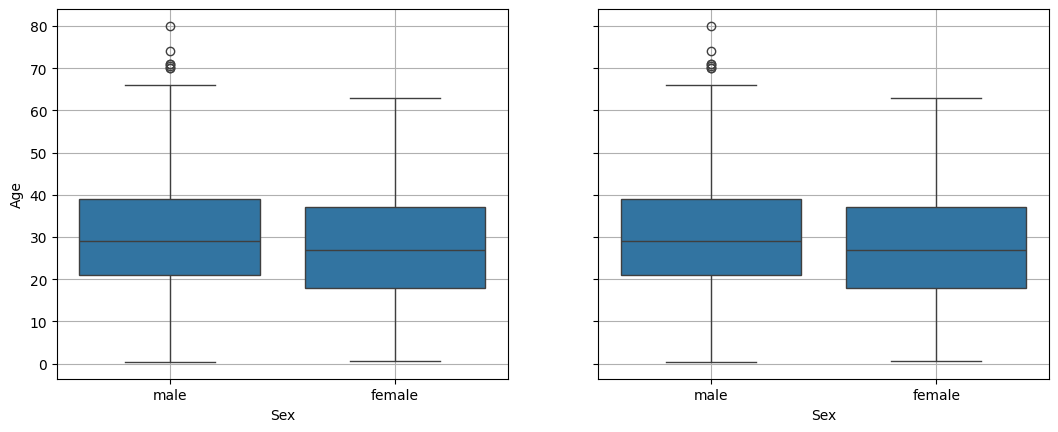

In [179]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))
sns.boxplot(df, x="Sex", y="Age", ax=axs[0])
sns.boxplot(df, x="Sex", y="Age", ax=axs[1])
axs[0].grid()
axs[1].grid()

## Age vs. TotalFam

In [36]:
famgroups = df["TotalFam"].map(lambda x: x if x <= 2 else 3)

In [38]:
# df.groupby(["TotalFam"]).Age.describe()
df.groupby(famgroups).Age.describe()

,count,mean,std,min,25%,50%,75%,max
TotalFam,,,,,,,,
0,404.0,32.220297,12.899871,5.00,22.00,29.5,39.00,80.0
1,139.0,31.391511,13.484379,0.42,22.00,29.0,42.00,65.0
2,93.0,26.035806,16.542123,0.67,15.00,27.0,37.00,70.0
3,78.0,17.992564,15.384191,0.75,4.25,14.0,25.75,64.0


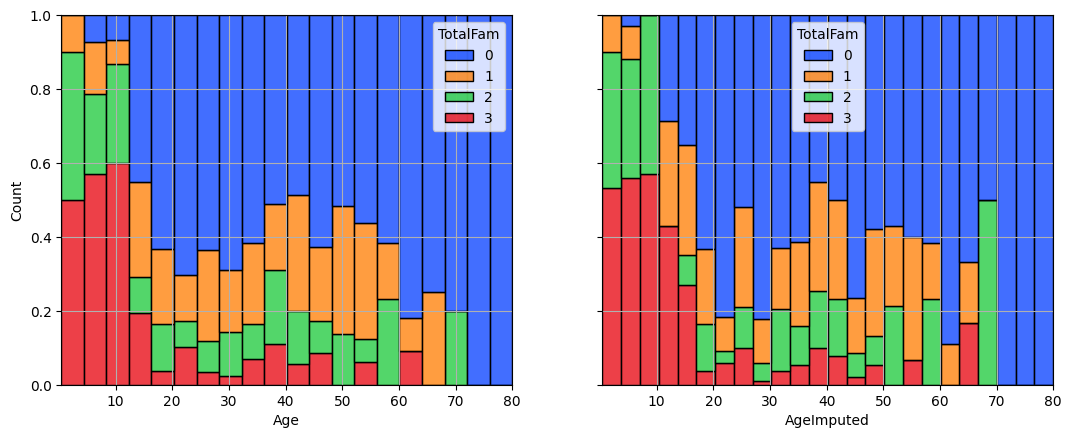

In [180]:
f, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12.8, 4.8))


sns.histplot(df, x="Age", hue=famgroups, palette="bright", multiple="fill", ax=axs[0])
sns.histplot(df, x="AgeImputed", hue=famgroups, palette="bright", multiple="fill", ax=axs[1])

axs[0].grid()
axs[1].grid()

## Age vs. Fare

In [ ]:
agebracket = (np.floor(df["Age"]/20)+1)*20

In [52]:
df.groupby(agebracket).Fare.describe()

,count,mean,std,min,25%,50%,75%,max
Age,,,,,,,,
20.0,164.0,31.794741,42.632362,0.0000,9.316675,19.2583,31.3875,263.0000
40.0,387.0,32.931200,58.927518,0.0000,7.925000,13.0000,27.7500,512.3292
60.0,137.0,41.481784,45.653935,0.0000,13.000000,26.2500,52.5542,247.5208
80.0,25.0,44.006668,52.252063,6.2375,10.500000,26.5500,61.9792,263.0000
100.0,1.0,30.000000,NaN,30.0000,30.000000,30.0000,30.0000,30.0000


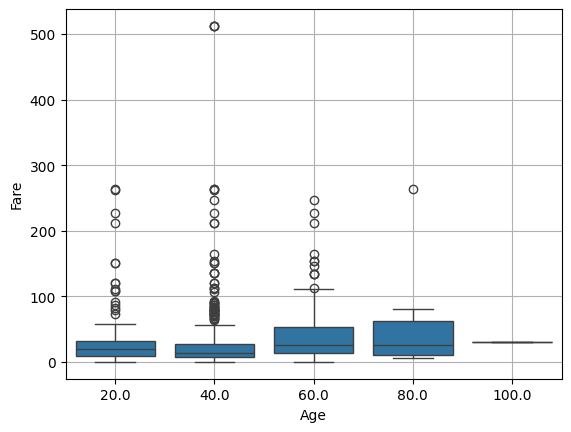

In [54]:
ax = sns.boxplot(df, x=agebracket, y="Fare")
ax.grid()

In [56]:
print(df["Fare"].describe())
print(np.quantile(df["Fare"], 0.9))
print(np.quantile(df["Fare"], 0.95))

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64
77.9583
112.07915


In [130]:
def get_farebracket(x):
    # if x <= 8:
    #     return 8
    # elif x <= 15:
    #     return 15
    # elif x <= 31:
    #     return 31
    # elif x <= 78:
    #     return 78
    # else:
    #     return 550
    if x <= 20:
        return 20
    else:
        return 550

farebrackets = df["Fare"].map(get_farebracket)

In [131]:
df.groupby(farebrackets).Age.describe()

,count,mean,std,min,25%,50%,75%,max
Fare,,,,,,,,
20,391.0,28.012583,12.244476,0.42,20.0,26.0,34.0,74.0
550,323.0,31.740712,16.674316,0.83,21.0,32.0,44.0,80.0


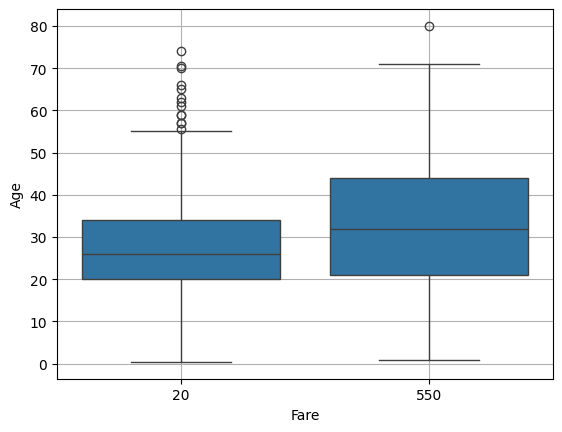

In [132]:
ax = sns.boxplot(df, x=farebrackets, y="Age")
ax.grid()

## Age imputation

In [95]:
def get_farebracket(x):
    if x <= 8:
        return 8
    elif x <= 15:
        return 15
    elif x <= 31:
        return 31
    elif x <= 78:
        return 78
    else:
        return 550

farebrackets = df["Fare"].map(get_farebracket)

In [206]:
famgroups = df["TotalFam"].map(lambda x: x if x <= 2 else 3)

In [161]:
pd.set_option('display.max_rows', None)
# df.groupby(["Titles", "Pclass", famgroups, farebrackets]).Age.describe().sort_values("count", ascending=False)
df.groupby(["Titles", "Pclass", famgroups]).Age.median()

Titles   Pclass  TotalFam
Master.  1       2            4.00
                 3            5.96
         2       2            1.50
                 3            1.00
         3       1            6.00
                 2            6.50
                 3            4.00
Miss.    1       0           30.00
                 1           23.00
                 2           26.50
                 3           19.50
         2       0           30.00
                 1           15.50
                 2            7.50
                 3            4.50
         3       0           22.00
                 1           16.25
                 2            4.00
                 3            7.00
Mr.      1       0           45.00
                 1           37.00
                 2           49.50
                 3           36.00
         2       0           30.00
                 1           32.50
                 2           31.00
                 3           25.00
         3       0           

In [158]:
df["AgeImputed"] = df["Age"]
df['AgeImputed'] = df['AgeImputed'].fillna(df.groupby(["Titles", "Pclass", famgroups])['Age'].transform('median'))

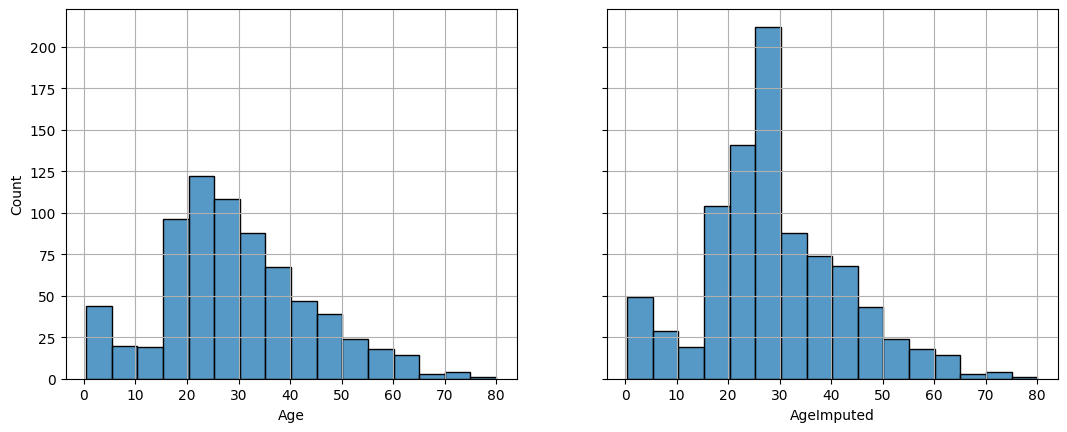

In [175]:
f, axs = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=[12.8, 4.8])
sns.histplot(df, x="Age", binwidth=5, ax=axs[0])
sns.histplot(df, x="AgeImputed", ax=axs[1], binwidth=5)
axs[0].grid()
axs[1].grid()

In [157]:
pd.set_option('display.max_rows', None)
df.loc[df["AgeMissing"] == True].groupby(["Titles", "Pclass", famgroups]).AgeMissing.count().sort_values(ascending=False)

Titles   Pclass  TotalFam
Mr.      3       0           77
         1       0           21
Miss.    3       0           19
Mr.      2       0            9
Miss.    3       3            7
Mrs.     1       1            7
Mr.      3       1            7
Mrs.     3       1            4
Mr.      3       3            4
Miss.    3       1            4
Mrs.     3       0            3
Miss.    3       2            3
         2       0            2
Master.  3       2            2
                 3            2
Mrs.     3       2            2
Mr.      3       2            2
Miss.    1       0            1
Mrs.     1       0            1
Name: AgeMissing, dtype: int64

## Missing Age pattern

In [101]:
df["AgeMissing"] = df["Age"].isna()

print(df["AgeMissing"].mean())
print("")
print(df.groupby(["AgeMissing"]).Survived.mean())
print("")
print(df.groupby(["Pclass"]).AgeMissing.mean().sort_index())
print("")
print(df.groupby(["Sex"]).AgeMissing.mean().sort_index())
print("")
print(df.groupby(["TotalFam"]).AgeMissing.mean().sort_index())
print("")
print(df.groupby(["AgeMissing"]).Fare.agg(["min", lambda x: x.quantile(0.25), "median", lambda x: x.quantile(0.75), "max"]))
print("")

0.19865319865319866

AgeMissing
False    0.406162
True     0.293785
Name: Survived, dtype: float64

Pclass
1    0.138889
2    0.059783
3    0.276986
Name: AgeMissing, dtype: float64

Sex
female    0.168790
male      0.214905
Name: AgeMissing, dtype: float64

TotalFam
0     0.247672
1     0.136646
2     0.088235
3     0.068966
4     0.266667
5     0.000000
6     0.000000
7     0.000000
10    1.000000
Name: AgeMissing, dtype: float64

            min  <lambda_0>   median  <lambda_1>       max
AgeMissing                                                
False       0.0        8.05  15.7417      33.375  512.3292
True        0.0        7.75   8.0500      24.150  227.5250



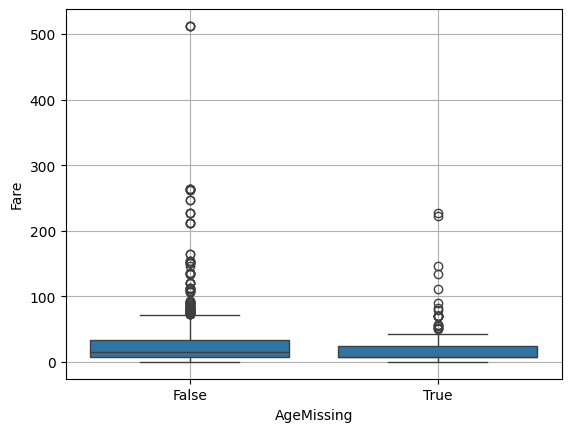

In [358]:
# ax = sns.countplot(df, x="AgeMissing", hue="Survived", stat="probability", palette="bright")
ax = sns.boxplot(df, x="AgeMissing", y="Fare")
ax.grid()

# SibSp, Parch - passthrough, and also add together to create TotalFam

Analysis:
* Most people have 0 to 2 family members on board. If you have 0 family members on board, your rate of survival is much less.

In [203]:
df["TotalFam"] = df["SibSp"] + df["Parch"]
df["TotalFam"].value_counts().sort_index()

TotalFam
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64

In [5]:
df["SibSp"].value_counts().sort_index()

SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: count, dtype: int64

In [396]:
df.groupby(["SibSp"]).Survived.mean()

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

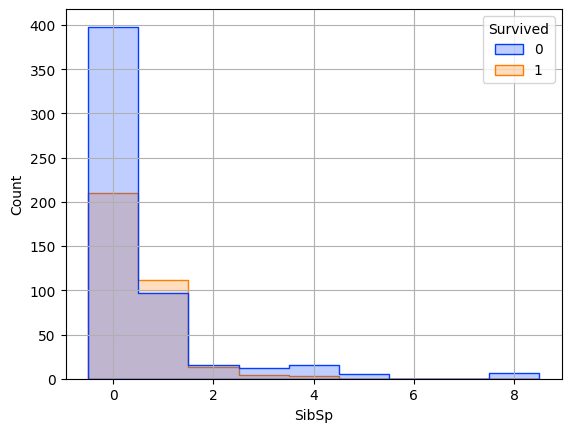

In [391]:
ax = sns.histplot(df, x="SibSp", hue="Survived", \
                  discrete=True, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

In [260]:
df["Parch"].value_counts().sort_index()

Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: count, dtype: int64

In [397]:
df.groupby(["Parch"]).Survived.mean()

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

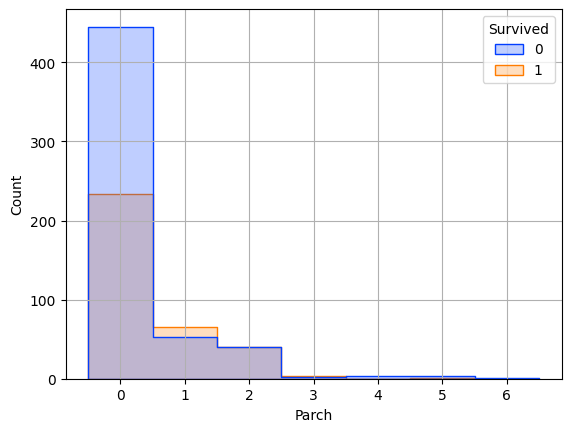

In [392]:
ax = sns.histplot(df, x="Parch", hue="Survived", \
                  discrete=True, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

In [ ]:
df.groupby(["TotalFam"]).Survived.mean()

TotalFam
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

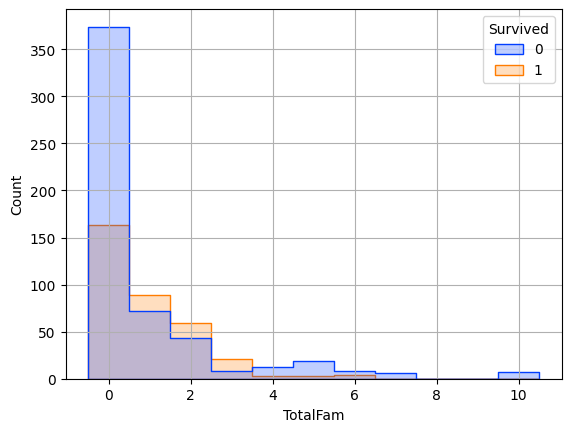

In [393]:
ax = sns.histplot(df, x="TotalFam", hue="Survived", \
                  discrete=True, multiple="layer", \
                  element="step", palette="bright")
ax.grid()

## TotalFam vs. other features

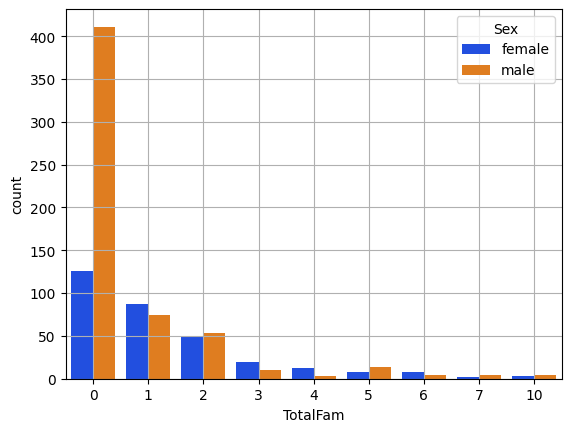

In [24]:
ax = sns.countplot(df, x="TotalFam", hue="Sex", palette="bright")
ax.grid()

# Fare - passthrough

Analysis:
* Lower Fare = lower rate of survival (I imagine it's similar to Pclass)

In [271]:
df["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

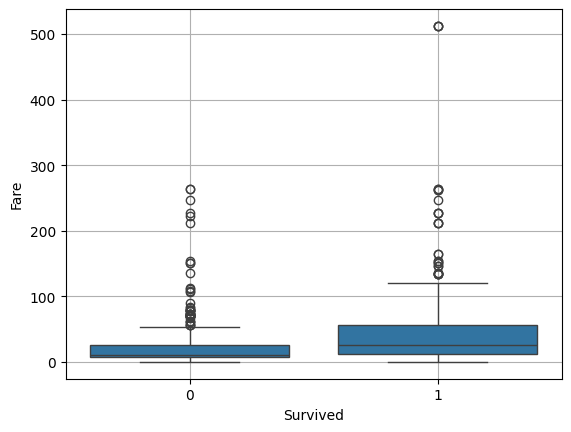

In [279]:
ax = sns.boxplot(df, y="Fare", x="Survived")
ax.grid()

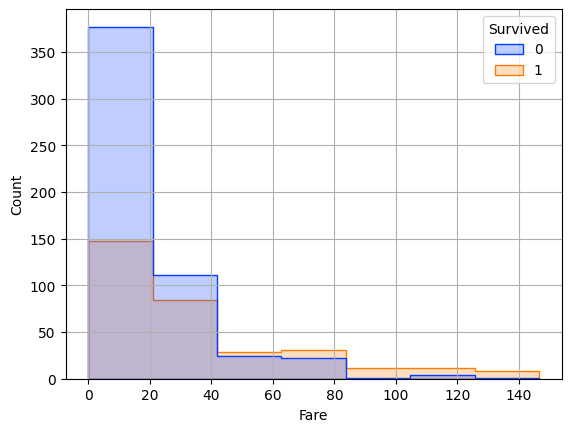

In [399]:
ax = sns.histplot(df.loc[df["Fare"] <= 150], x="Fare", hue="Survived", \
                  multiple="layer", binwidth=20, \
                  element="step", palette="bright")
ax.grid()

# Name

Analysis:
* 4 main titles: Mr., Master., Mrs., Miss.
    * Master is for really young males
    * Mrs vs. Miss: Miss is younger, usually doesn't have family, and is much more likely to be in Pclass3
        * Set Miss = less than 30 years and no family

In [84]:
df["Name"].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [204]:
def name_proc(x):
    return x.strip().split(",")[1].strip().split()[0]

df["Titles"] = df["Name"].map(name_proc)

df["Titles"].value_counts()

Titles
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Ms.            1
Mme.           1
Don.           1
Lady.          1
Sir.           1
Capt.          1
the            1
Jonkheer.      1
Name: count, dtype: int64

In [205]:
titles_small_samples = df["Titles"].value_counts().index[df["Titles"].value_counts() < 10]
df.loc[(df["Titles"].isin(titles_small_samples)) & \
       (df["Sex"] == "female") & (df["Age"] <= 30), "Titles"] = "Miss."
df.loc[(df["Titles"].isin(titles_small_samples)) & \
       (df["Sex"] == "female") & (df["Age"] > 30), "Titles"] = "Mrs."
df.loc[(df["Titles"].isin(titles_small_samples)) & \
       (df["Sex"] == "male") & (df["Age"] > 12), "Titles"] = "Mr."
df.loc[(df["Titles"] == "Dr.") & (df["Sex"] == "male"), "Titles"] = "Mr."

df["Titles"].value_counts()

Titles
Mr.        537
Miss.      186
Mrs.       128
Master.     40
Name: count, dtype: int64

In [94]:
print(df.groupby(["Sex"]).Titles.unique())
print("")
print(df.groupby(["Titles"]).Age.describe().sort_values("count", ascending=False))
print("")
print(df.loc[df["Titles"].isin(["Miss.", "Mrs."])].groupby(["TotalFam"]).Titles.value_counts().sort_index())
print("")
print(df.loc[df["Titles"].isin(["Miss.", "Mrs."])].groupby("Pclass").Titles.value_counts().sort_index())

Sex
female     [Mrs., Miss.]
male      [Mr., Master.]
Name: Titles, dtype: object

         count       mean        std    min     25%   50%   75%   max
Titles                                                               
Mr.      417.0  32.984412  12.988220  11.00  23.000  30.0  40.0  80.0
Miss.    150.0  21.860000  12.828485   0.75  14.625  21.5  30.0  63.0
Mrs.     111.0  36.099099  11.405704  14.00  28.000  35.0  44.5  63.0
Master.   36.0   4.574167   3.619872   0.42   1.000   3.5   8.0  12.0

TotalFam  Titles
0         Miss.     104
          Mrs.       22
1         Miss.      27
          Mrs.       60
2         Miss.      22
          Mrs.       27
3         Miss.      10
          Mrs.        9
4         Miss.       9
          Mrs.        3
5         Miss.       4
          Mrs.        4
6         Miss.       6
          Mrs.        2
7         Miss.       1
          Mrs.        1
10        Miss.       3
Name: count, dtype: int64

Pclass  Titles
1       Miss.      49
       

## Investigate titles

In [70]:
titles_small_samples = df["Titles"].value_counts().index[df["Titles"].value_counts() < 10]

In [72]:
df.loc[(df["Titles"].isin(titles_small_samples)) & (df["Sex"] == "female")].sort_values(by="Age")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalFam,Titles,AgeMissing
369,370,1,1,"Aubart, Mme. Leontine Pauline",female,24.0,0,0,PC 17477,69.3000,B35,C,0,Mme.,False
641,642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,0,Mlle.,False
710,711,1,1,"Mayne, Mlle. Berthe Antonine (""Mrs de Villiers"")",female,24.0,0,0,PC 17482,49.5042,C90,C,0,Mlle.,False
443,444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0000,NaN,S,0,Ms.,False
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5000,B77,S,0,the,False
556,557,1,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",female,48.0,1,0,11755,39.6000,A16,C,1,Lady.,False
796,797,1,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,0,Dr.,False


In [73]:
df.loc[(df["Titles"].isin(titles_small_samples)) & (df["Sex"] == "male")].sort_values(by="Age")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TotalFam,Titles,AgeMissing
398,399,0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,0,Dr.,False
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Rev.,False
848,849,0,2,"Harper, Rev. John",male,28.0,0,1,248727,33.0000,NaN,S,1,Rev.,False
632,633,1,1,"Stahelin-Maeglin, Dr. Max",male,32.0,0,0,13214,30.5000,B50,C,0,Dr.,False
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S,0,Jonkheer.,False
30,31,0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,0,Don.,False
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0000,NaN,S,0,Rev.,False
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q,2,Dr.,False
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S,0,Major.,False
599,600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",male,49.0,1,0,PC 17485,56.9292,A20,C,1,Sir.,False


# Ticket - drop

In [269]:
df["Ticket"].sample(20)

459             371060
252             113514
408             312992
357             237671
384             349227
795              28213
500             315086
176               4133
856              36928
391             350034
568               2686
870             349248
63              347088
310              11767
739             349218
11              113783
157    SOTON/OQ 392090
264             382649
471             315089
661               2623
Name: Ticket, dtype: object

# Cabin - ordinal encoding - passthrough, drop, missing indicator, or impute

Analysis:
* Non-missing Cabins is a very small sample size; survival rate is 67% which is much higher than overall. I'm not sure if you can infer anything from this.
* Some entries have multiple Cabins listed - for these, I will take the first one listed
* Some Cabins don't have numbers - put NaN for these
* PassengerId=340 - Cabin T (error). This is a first-class passenger, so this should be A through E. Set it to C as this is the mode of CabinLetter for first-class passengers.
* Survival distribution is exactly the same across CabinNumber (CabinNumber does not affect survival rate)

Missing analysis:
* Most Cabins are missing; survival rate for these is 30%, much lower than overall
* Mostly Pclass 2 or 3 passengers
* Having a Cabin is so strongly correlated with Pclass (which is correlated with Age and Fare); it may not add much information
* You should drop CabinNumber - no way to impute and most of the values are missing
* CabinLetter
    * Passthrough
    * Drop
    * Passthrough with additional missing category
    * Impute and add missing indicator feature
        * Impute by taking mode per Pclass - does this add any information on top of Pclass?
        * Impute using supervised learning with Pclass, Age, Fare

## CabinLetter, CabinNumber

In [193]:
def cab_letter(x):
    x = x.strip().split()[0][0]
    return x

def cab_number(x):
    x = x.strip().split()[0][1:]
    return x

df["CabinLetter"] = df["Cabin"].str[0].fillna("M")
df["CabinLetter"] = df["CabinLetter"].replace("T", "C")

print(df["CabinLetter"].value_counts().sort_index())
# df.loc[df["CabinNumber"] == "", "CabinNumber"] = np.nan
# df["CabinNumber"] = df["CabinNumber"].astype(float)
# df["CabinNumber"].describe()

CabinLetter
A     15
B     47
C     60
D     33
E     32
F     13
G      4
M    687
Name: count, dtype: int64


In [28]:
print(df.groupby(["Pclass", "CabinLetter"]).PassengerId.count())
print(df.groupby(["CabinLetter"]).Survived.mean())
# print(df.groupby(["CabinLetter"]).Survived.value_counts())

Pclass  CabinLetter
1       A               15
        B               47
        C               60
        D               29
        E               25
        M               40
2       D                4
        E                4
        F                8
        M              168
3       E                3
        F                5
        G                4
        M              479
Name: PassengerId, dtype: int64
CabinLetter
A    0.466667
B    0.744681
C    0.583333
D    0.757576
E    0.750000
F    0.615385
G    0.500000
M    0.299854
Name: Survived, dtype: float64


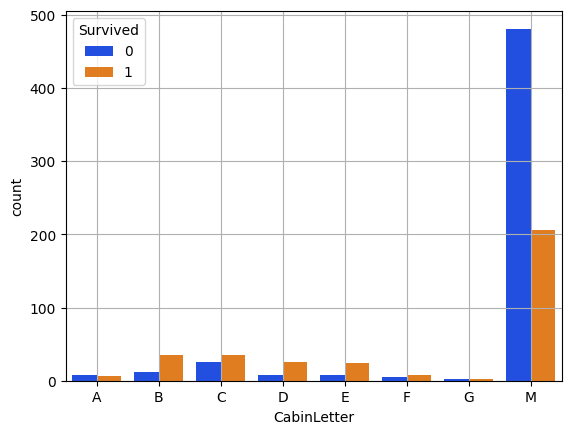

In [33]:
ax = sns.countplot(df, x="CabinLetter", order=sorted(df.CabinLetter.unique()), hue="Survived", palette="bright")
ax.grid()

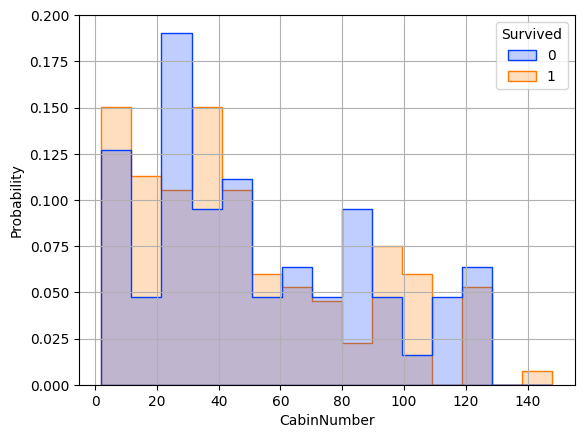

In [8]:
ax = sns.histplot(df, x="CabinNumber", binwidth=10, hue="Survived", palette="bright", multiple="layer", element="step", stat="probability", common_norm=False)
ax.grid()

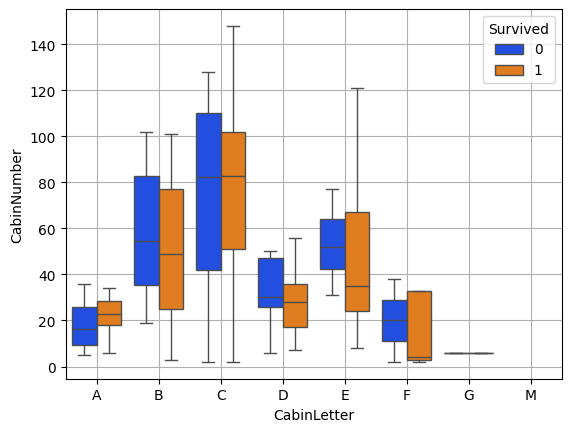

In [34]:
ax = sns.boxplot(df, x="CabinLetter", y="CabinNumber", hue="Survived", palette="bright", order=sorted(df.CabinLetter.unique()))
ax.grid()

## CabinLetter vs. other features

In [26]:
print(df.groupby(["Pclass"]).CabinLetter.value_counts().sort_index())
print("")
print(df.groupby(["CabinLetter"]).Age.describe())
print("")
# print(df.groupby(["TotalFam"]).CabinLetter.value_counts().sort_index())
print(df.groupby(["CabinLetter"]).TotalFam.describe())
print("")
print(df.groupby(["CabinLetter"]).Fare.describe())
print("")
# print(df.groupby(["Embarked"]).CabinLetter.value_counts().sort_index())
# print(df.groupby(["CabinLetter"]).Embarked.value_counts().sort_index())

Pclass  CabinLetter
1       A              15
        B              47
        C              60
        D              29
        E              25
2       D               4
        E               4
        F               8
3       E               3
        F               5
        G               4
Name: count, dtype: int64

             count       mean        std    min    25%   50%    75%   max
CabinLetter                                                              
A             12.0  44.833333  20.171237   4.00  34.75  44.0  56.00  80.0
B             45.0  34.955556  15.491868  11.00  24.00  33.0  44.00  70.0
C             52.0  36.258077  14.291361   0.92  25.75  36.5  47.25  64.0
D             31.0  39.032258  14.460253  16.00  25.00  37.0  50.00  63.0
E             30.0  38.116667  12.590146   6.00  30.50  39.0  47.00  65.0
F             11.0  19.954545  15.182975   1.00   3.50  24.0  31.50  42.0
G              4.0  14.750000  13.744696   2.00   3.50  14.0  25.25  29.0



,count,mean,std,min,25%,50%,75%,max
CabinLetter,,,,,,,,
A,12.0,44.833333,20.171237,4.00,34.75,44.0,56.00,80.0
B,45.0,34.955556,15.491868,11.00,24.00,33.0,44.00,70.0
C,52.0,36.258077,14.291361,0.92,25.75,36.5,47.25,64.0
D,31.0,39.032258,14.460253,16.00,25.00,37.0,50.00,63.0
E,30.0,38.116667,12.590146,6.00,30.50,39.0,47.00,65.0
F,11.0,19.954545,15.182975,1.00,3.50,24.0,31.50,42.0
G,4.0,14.750000,13.744696,2.00,3.50,14.0,25.25,29.0


## Missing Cabin

In [11]:
df["CabinMissing"] = df["Cabin"].isna()

print(df.groupby(["CabinMissing"]).Survived.mean())
df.groupby(["Pclass"]).CabinMissing.mean()

CabinMissing
False    0.666667
True     0.299854
Name: Survived, dtype: float64


Pclass
1    0.185185
2    0.913043
3    0.975560
Name: CabinMissing, dtype: float64

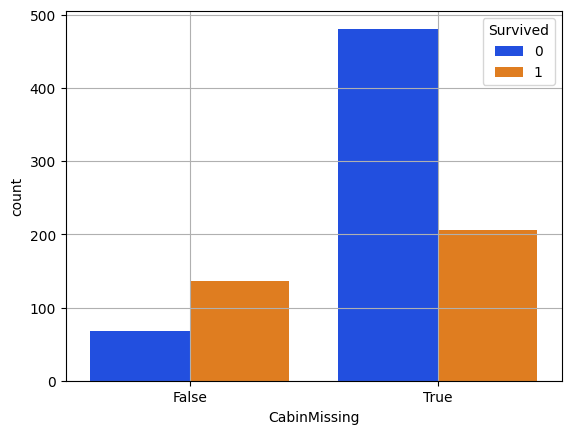

In [412]:
ax = sns.countplot(df, x="CabinMissing", hue="Survived", palette="bright")
ax.grid()

In [38]:
print(df.groupby(["CabinMissing"]).Age.describe())
print("")
print(df.groupby(["CabinMissing"]).Pclass.value_counts().sort_index())
print("")
print(df.groupby(["CabinMissing"]).Fare.describe())

              count       mean        std   min   25%   50%   75%   max
CabinMissing                                                           
False         185.0  35.829297  15.679356  0.92  24.0  36.0  48.0  80.0
True          529.0  27.555293  13.472634  0.42  19.0  26.0  35.0  74.0

CabinMissing  Pclass
False         1         176
              2          16
              3          12
True          1          40
              2         168
              3         479
Name: count, dtype: int64

              count       mean        std  min        25%       50%       75%  \
CabinMissing                                                                    
False         204.0  76.141504  74.391749  0.0  29.453125  55.22085  89.32815   
True          687.0  19.157325  28.663343  0.0   7.877100  10.50000  23.00000   

                   max  
CabinMissing            
False         512.3292  
True          512.3292  


# Embarked

In [182]:
df["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [183]:
df.groupby(["Embarked"]).Survived.mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

# def prepare_dataframe

In [219]:
def prepare_dataframe(df, age_strategy="group_median", use_cabin=True, use_embarked=False):
    df = df.copy()

    # Process Name
    df["Title"] = df["Name"].map(lambda x: x.strip().split(",")[1].strip().split()[0])
    titles_small_samples = df["Title"].value_counts().index[df["Title"].value_counts() < 10]
    df.loc[(df["Title"].isin(titles_small_samples)) & \
        (df["Sex"] == "female") & (df["Age"] <= 30), "Title"] = "Miss."
    df.loc[(df["Title"].isin(titles_small_samples)) & \
        (df["Sex"] == "female") & (df["Age"] > 30), "Title"] = "Mrs."
    df.loc[(df["Title"].isin(titles_small_samples)) & \
        (df["Sex"] == "male") & (df["Age"] > 12), "Title"] = "Mr."
    df.loc[(df["Title"] == "Dr.") & (df["Sex"] == "male"), "Title"] = "Mr."

    df["TotalFam"] = df["SibSp"] + df["Parch"]
    famgroups = df["TotalFam"].map(lambda x: x if x <= 2 else 3)

    if age_strategy == "group_median":
        df["AgeMissing"] = df["Age"].isna().astype(int)
        group_median = (df.groupby(["Title", "Pclass", famgroups]).Age
                        .transform("median")
                        )
        df["Age"] = df["Age"].fillna(group_median)

    if use_cabin:
        df["CabinLetter"] = df["Cabin"].str[0].fillna("M")
        df["CabinLetter"] = df["CabinLetter"].replace("T", "C")

    if not use_embarked:
        df = df.drop("Embarked", axis="columns")
    
    df = df.drop(["PassengerId", "Ticket", "Name", "Cabin"], axis="columns")

    return df

df = prepare_dataframe(df)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title,TotalFam,AgeMissing,CabinLetter
0,0,3,male,22.0,1,0,7.2500,Mr.,1,0,M
1,1,1,female,38.0,1,0,71.2833,Mrs.,1,0,C
2,1,3,female,26.0,0,0,7.9250,Miss.,0,0,M
3,1,1,female,35.0,1,0,53.1000,Mrs.,1,0,C
4,0,3,male,35.0,0,0,8.0500,Mr.,0,0,M


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Title        891 non-null    object 
 8   TotalFam     891 non-null    int64  
 9   AgeMissing   891 non-null    int64  
 10  CabinLetter  891 non-null    object 
dtypes: float64(2), int64(6), object(3)
memory usage: 76.7+ KB


In [221]:
print(df.select_dtypes(include=["object"]).columns)
print(df.select_dtypes(exclude=["object"]).columns)

Index(['Sex', 'Title', 'CabinLetter'], dtype='object')
Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TotalFam',
       'AgeMissing'],
      dtype='object')


In [226]:
ord_features = ["Sex"]
if "CabinLetter" in df.columns:
    ord_features.append("CabinLetter")
onehot_features = ["Title"]
if "Embarked" in df.columns:
    onehot_features.append("Embarked")
num_features = df.select_dtypes(exclude=["object"]).columns
print(ord_features)
print(onehot_features)
print(num_features)

['Sex', 'CabinLetter']
['Title']
Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'TotalFam',
       'AgeMissing'],
      dtype='object')


In [227]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

enc = OrdinalEncoder()

enc.fit(df[["CabinLetter"]])
enc.fit(df[["Sex"]])
enc.categories_

[array(['female', 'male'], dtype=object)]

In [ ]:
X = df.drop("Survived", axis=1)
y = df["Survived"].to_numpy()

ord_features = ["Sex"]
if "CabinLetter" in df.columns:
    ord_features.append("CabinLetter")
onehot_features = ["Title"]
if "Embarked" in df.columns:
    onehot_features.append("Embarked")
num_features = df.select_dtypes(exclude=["object"]).columns

preprocessor = ColumnTransformer([
    ("num", "passthrough", num_features),
    ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ord_features),
    ("onehot", OneHotEncoder(handle_unknown="infrequent_if_exist"), onehot_features)
])

# model = RandomForestClassifier(**EXPERIMENT_CONFIG["model_params"])
model = RandomForestClassifier()

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", model)
])

# Encoding

In [5]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

enc = OneHotEncoder()
enc.fit(df[["Sex"]])


OneHotEncoder()

In [12]:
print(enc.categories_)
enc.transform(df[["Sex"]])

[array(['female', 'male'], dtype=object)]


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 891 stored elements and shape (891, 2)>

In [17]:
enc = OrdinalEncoder()
enc.fit(df[["Pclass"]])

OrdinalEncoder()

In [18]:
print(enc.categories_)
enc.transform(df[["Pclass"]])

[array([1, 2, 3])]


array([[2.],
       [0.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [1.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [1.],
       [1.],
       [2.],
       [0.],
       [2.],
       [2.],
       [2.],
       [0.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [1.],
       [0.],
       [0.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [2.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [0.],
       [0.],
       [2.],
       [0.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [1.],
       [2.],
       [1.],
       [2.],
       [2.],
       [2.],
       [2.],

# Train-val split

In [22]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

X = df.drop("Survived", axis="columns")
y = df["Survived"].copy()

for train_idx, val_idx in skf.split(X, y):
    print(train_idx)
    print(val_idx)
    print('---')

[  0   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18
  19  20  21  22  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  57
  58  59  60  61  62  63  64  65  66  67  68  70  71  72  74  75  76  77
  78  79  80  81  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 109 110 111 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 129 130 131 132 133 134 135 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 153 155 156 157
 158 159 160 161 162 163 164 166 167 168 169 170 171 172 173 174 175 176
 177 178 179 180 182 183 185 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 214 215 216
 217 219 220 221 222 223 224 225 226 227 230 231 233 234 235 236 237 238
 239 240 241 242 243 246 247 248 249 250 251 252 254 255 256 257 258 259
 260 261 262 263 264 265 266 267 268 269 270 273 27

# Pipeline

In [24]:
model = DecisionTreeClassifier()
# model = RandomForestClassifier()
# model = RandomForestClassifier(class_weight="balanced")
# model = RandomForestClassifier(class_weight="balanced_subsample")
# model = HistGradientBoostingClassifier()

data_pipe = ColumnTransformer([
    ("scaler_only", StandardScaler(), ["Fare", "Age", "SibSp", "Parch"]),
    ("ordinal_encoder", OrdinalEncoder(), ["Sex"]),
    ("onehot_encoder", OneHotEncoder(), ["Embarked", "Pclass"]),
    # ("labels", "passthrough", ["Survived"])
])

ml_pipe = Pipeline([
    ("preprocess", data_pipe),
    ("model", model)
])

In [28]:
dir(ml_pipe.named_steps.model)

['_BaseDecisionTree__metadata_request__predict',
 '_DecisionTreeClassifier__metadata_request__fit',
 '_DecisionTreeClassifier__metadata_request__predict_proba',
 '__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_compute_missing_values_in_feature_mask',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_fit',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags'